## Background filter process:

- replot only the background noise
- extract numbers and find max
    - find the average and then anything above that average? can be creative and think about this
    - return the indices
- create a new array that is the same length as the background full of 1, and then at every index switch to a 0
- pass the signal through this array and see what that looks like
- get matrix of new signal and get new SNR? (idk lets just go from there)

12/17/20: change input to band r for visible for scorpio, keep same input spectrum

In [46]:
import os
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip, mad_std
from scipy.signal import find_peaks

init_notebook_mode(connected=True)


### Read the throughput files

All tables are COLUMNS x ROW, i.e. (100 x 2) or .shape=>(100,2)
- this is the standard format of those read by file
- those written explicitely below may need to be transposed (i.e. lam1...lamN must be a column)

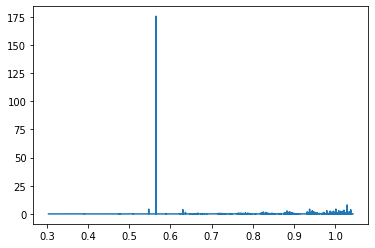

In [75]:
#reading the files

homedir = os.path.join(os.getcwd(),"etc_data")

#Throughput
#==============================================================================
#0) Metals for telescope optics (and possibly other mirrors)
# Al from National Bureau of Standards, certainly optimistic
Al_reflectivity = np.loadtxt(os.path.join(homedir,"general/coating_throughput","Al_reflectance_NBS.txt")) #lambda[nm], transmission
Al_reflectivity[:,0] =  Al_reflectivity[:,0] * 1E-3 #nm -< [micron]
#Al_reflectivity.shape #(25,2)

#For Gemini, measured on site, average
Silver_reflectivity = np.loadtxt(os.path.join(homedir,"general/coating_throughput","SilverCoating_ALL.txt")) #lambda[nm], transmission
Silver_reflectivity[:,0] =  Silver_reflectivity[:,0] * 1E-3 #nm -< [micron]
#Silver_reflectivity.shape  # (221,2)

#;  if telescope EQ 'GEMS f/33' then throughput*=0.7
#  throughput*=0.9

#1) Instruments
#==============================================================================
#A) ATLAS
ATLAS_throughput = np.loadtxt(os.path.join(homedir,"ATLAS/spec_throughput","throughputSpec_atlas_IR.txt")) #lambda[micron], transmission
#ATLAS_throughput.shape # (171,2)

#==============================================================================
#B) SAMOS
#SAM throughput
SAM_wl = [0.4,1.0]
SAM_th = [0.9,0.9]

#SAMOS_throughput_OPTICS 
SAMOS_wl_th = np.array([400, 450, 500, 550, 600, 700, 770, 850, 950]) * 1E-3 #;nm->[micron]
SAMOS_Optics_th  = [0.692, 0.770, 0.793, 0.793, 0.787, 0.792, 0.796, 0.794, 0.703]
SAMOS_Optics_throughput = np.transpose(np.array([SAMOS_wl_th,SAMOS_Optics_th]))
#SAMOS_Optics_throughput.shape (9,2) 

#SAMOS_throughput_SAMI
SAMI_CCD_wl = np.array([400, 450, 500, 550, 600, 700, 770, 850, 950]) * 1E-3 #;nm->[micron]
SAMI_CCD_QE     = [0.679, 0.875, 0.879, 0.836, 0.865, 0.885, 0.885, 0.834, 0.677]
SAMOS_CCD_throughput = np.transpose(np.array([SAMI_CCD_wl,SAMI_CCD_QE]))
#SAMOS_CCD_throughput.shape # (9,2)

#SAMOS_throughput_DMD
DMD_efficiency_wl = np.array([400, 450, 500, 550, 600, 700, 770, 850, 950]) * 1E-3 #;nm->[micron]
DMD_efficiency_table   = [0.667, 0.680, 0.680, 0.680, 0.680, 0.680, 0.680, 0.680, 0.667]
SAMOS_DMD_throughput = np.transpose(np.array([DMD_efficiency_wl,DMD_efficiency_table]))

#SAMOS_throughput_VPH
Blue_VPH_wl = np.array([400, 450, 500, 550, 600, 700, 770, 850, 950]) * 1E-3 #;nm->[micron]
Blue_VPH_th      = [0.679, 0.875, 0.879, 0.836, 0.685, 0.   , 0.   , 0.   , 0.   ]
SAMOS_LowBlueVPH_throughput = np.transpose(np.array([Blue_VPH_wl,Blue_VPH_th]))
Red_VPH_wl = np.array([400, 450, 500, 550, 600, 700, 770, 850, 950]) * 1E-3 #;nm->[micron]
Red_VPH_th       = [0.   , 0.   , 0.   , 0.   , 0.685, 0.885, 0.885, 0.834, 0.677]
SAMOS_LowRedVPH_throughput = np.transpose(np.array([Red_VPH_wl,Red_VPH_th]))
Ha_VPH_wl      = np.array([0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71]) * 1E3 #;nm
Ha_VPH_th      = [0.73, 0.80, 0.87, 0.92, 0.95, 0.97, 0.97, 0.96, 0.93, 0.90, 0.84, 0.78, 0.71]
SAMOS_HighRedVPH_throughput = np.transpose(np.array([Ha_VPH_wl,Ha_VPH_th]))

#==============================================================================
#C) SCORPIO
#Gemini Telescope 
Gemini_throughput = pd.read_table(os.path.join(homedir,"SCORPIO/SpecEff","Gemini_3M.txt"),skiprows=1,header=0) #lambda[micron], transmission
df=Gemini_throughput.transpose() #trasposed has column headers as first row values: fix it... 
new_header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
df.columns = new_header #set the header row as the df header. 
wl=np.asarray(df.index, dtype=np.float)*1E-3  #wavelenghts is the df.index in nm; convert to np.float and to micron
Gemini_throughput = np.array([wl,df['GEMINI 3M']]) # #lambda[micron], transmission 
Gemini_throughput = np.transpose(Gemini_throughput)
#Gemini_throughput.shape  # (22,2)
#
SCORPIO_throughput_ADC = np.loadtxt(os.path.join(homedir,"SCORPIO/SpecEff","octocam_ADC.txt"),skiprows=1) #lambda[micron], transmission
#SCORPIO_throughput_ADC = np.transpose(SCORPIO_throughput_ADC)
SCORPIO_throughput_ADC[:,0] = SCORPIO_throughput_ADC[:,0] * 1E-3
# SCORPIO_throughput_ADC.shape # (2,22)
#
SCORPIO_throughput_g = np.loadtxt(os.path.join(homedir,"SCORPIO/SpecEff","octocam_SDSS_g.txt"),skiprows=1) #lambda[micron], transmission
#SCORPIO_throughput_g = np.transpose(SCORPIO_throughput_g)
SCORPIO_throughput_r = np.loadtxt(os.path.join(homedir,"SCORPIO/SpecEff","octocam_SDSS_r.txt"),skiprows=1) #lambda[micron], transmission
#SCORPIO_throughput_r = np.transpose(SCORPIO_throughput_r)
SCORPIO_throughput_i = np.loadtxt(os.path.join(homedir,"SCORPIO/SpecEff","octocam_SDSS_i.txt"),skiprows=1) #lambda[micron], transmission
#SCORPIO_throughput_i = np.transpose(SCORPIO_throughput_i)
SCORPIO_throughput_z = np.loadtxt(os.path.join(homedir,"SCORPIO/SpecEff","octocam_SDSS_z.txt"),skiprows=1) #lambda[micron], transmission
#SCORPIO_throughput_z = np.transpose(SCORPIO_throughput_z)
SCORPIO_throughput_Y = np.loadtxt(os.path.join(homedir,"SCORPIO/SpecEff","octocam_Y.txt"),skiprows=1) #lambda[micron], transmission
#SCORPIO_throughput_Y = np.transpose(SCORPIO_throughput_Y)
SCORPIO_throughput_J = np.loadtxt(os.path.join(homedir,"SCORPIO/SpecEff","octocam_J.txt"),skiprows=1) #lambda[micron], transmission
#SCORPIO_throughput_J = np.transpose(SCORPIO_throughput_J)
SCORPIO_throughput_H = np.loadtxt(os.path.join(homedir,"SCORPIO/SpecEff","octocam_H.txt"),skiprows=1) #lambda[micron], transmission
#SCORPIO_throughput_H = np.transpose(SCORPIO_throughput_H)
SCORPIO_throughput_K = np.loadtxt(os.path.join(homedir,"SCORPIO/SpecEff","octocam_K.txt"),skiprows=1) #lambda[micron], transmission
#SCORPIO_throughput_K = np.transpose(SCORPIO_throughput_K)
# SCORPIO_throughput_J.shape (2,7)

#==============================================================================
#Atmospheric Transmission
#==============================================================================
AtmosphericExtinction_IR = np.loadtxt(os.path.join(homedir,"general/AtmosphericExtinction","Extinction_IR.txt"),skiprows=1) #lambda[micron], transmission
#AtmosphericExtinction_IR = np.transpose(AtmosphericExtinction_IR) #[micron, throughput]
#AtmosphericExtinction_IR.shape # (2,16198)
AtmosphericExtinction_IR[:,0] = AtmosphericExtinction_IR[:,0] *1E-4 # A => [micron]
AtmosphericExtinction_VIS = np.loadtxt(os.path.join(homedir,"general/AtmosphericExtinction","Extinction_VIS.txt"),skiprows=1) #lambda[micron], transmission
#AtmosphericExtinction_VIS = np.transpose(AtmosphericExtinction_VIS) #[micron, throughput]
#AtmosphericExtinction_VIS.shape # (2,7199)
AtmosphericExtinction_VIS[:,0] = AtmosphericExtinction_VIS[:,0] *1E-4 # A => [micron]

#==============================================================================
#Bandpasses
#==============================================================================
#A) ATLAS
spec_bandpass_ATLAS = np.loadtxt(os.path.join(homedir,"ATLAS/bandpass","bandpass_atlas_IR.txt"))  #lambda[micron], transmission either 0 or 1
#spec_bandpass_ATLAS = np.transpose(spec_bandpass_ATLAS)
#SAMOS_bandpass_HighRed.shape # (4,2)

#B) SAMOS
#a1 = (np.array([x for x in range(2001)])+4000)*1E-4  # [micron]
#a2 = np.array([1]*2001)
#spec_bandpass_LowBlue=np.transpose(np.array([ a1, a2 ]))
#a1 = (np.array([x for x in range(3501)])+6000)*1E-4  # [micron]
#a2 = np.array([1]*3501)
#spec_bandpass_LowRed=np.transpose(np.array([ a1, a2 ]))
#a1 = (np.array([x for x in range(636)])+4504)*1E-4  # [micron]
#a2 = np.array([1]*636)
#spec_bandpass_HighBlue=np.transpose(np.array([ a1, a2 ]))
#a1 = (np.array([x for x in range(1013)])+5988)*1E-4  # [micron]
#a2 = np.array([1]*1013)
#spec_bandpass_HighRed=np.transpose(np.array([ a1, a2 ]))

SAMOS_bandpass_LowBlue = np.loadtxt(os.path.join(homedir,"SAMOS/bandpass","samos_Blue.txt")) #lambda[micron], transmission
#SAMOS_bandpass_LowBlue = np.transpose(SAMOS_bandpass_LowBlue)
SAMOS_bandpass_LowRed = np.loadtxt(os.path.join(homedir,"SAMOS/bandpass","samos_Red.txt")) #lambda[micron], transmission
#SAMOS_bandpass_LowRed = np.transpose(SAMOS_bandpass_LowRed)
SAMOS_bandpass_HighBlue = np.loadtxt(os.path.join(homedir,"SAMOS/bandpass","samos_Hb.txt")) #lambda[micron], transmission
#SAMOS_bandpass_HighBlue = np.transpose(SAMOS_bandpass_HighBlue)
SAMOS_bandpass_HighRed = np.loadtxt(os.path.join(homedir,"SAMOS/bandpass","samos_Ha.txt")) #lambda[micron], transmission
#SAMOS_bandpass_HighRed = np.transpose(SAMOS_bandpass_HighRed)
# SAMOS_bandpass_HighRed.shape # (2,4)

#C) SCORPIO
SCORPIO_bandpass_g = np.loadtxt(os.path.join(homedir,"SCORPIO/bandpass","octocam_SDSS_g.txt")) #lambda[micron], transmission
#SCORPIO_bandpass_g = np.transpose(SCORPIO_bandpass_g)
SCORPIO_bandpass_r = np.loadtxt(os.path.join(homedir,"SCORPIO/bandpass","octocam_SDSS_r.txt")) #lambda[micron], transmission
#SCORPIO_bandpass_r = np.transpose(SCORPIO_bandpass_r)
SCORPIO_bandpass_i = np.loadtxt(os.path.join(homedir,"SCORPIO/bandpass","octocam_SDSS_i.txt")) #lambda[micron], transmission
#SCORPIO_bandpass_i = np.transpose(SCORPIO_bandpass_i)
SCORPIO_bandpass_z = np.loadtxt(os.path.join(homedir,"SCORPIO/bandpass","octocam_SDSS_z.txt")) #lambda[micron], transmission
#SCORPIO_bandpass_z = np.transpose(SCORPIO_bandpass_z)
SCORPIO_bandpass_Y = np.loadtxt(os.path.join(homedir,"SCORPIO/bandpass","octocam_Y.txt")) #lambda[micron], transmission
#SCORPIO_bandpass_Y = np.transpose(SCORPIO_bandpass_Y)
SCORPIO_bandpass_J = np.loadtxt(os.path.join(homedir,"SCORPIO/bandpass","octocam_J.txt")) #lambda[micron], transmission
#SCORPIO_bandpass_J = np.transpose(SCORPIO_bandpass_J)
SCORPIO_bandpass_H = np.loadtxt(os.path.join(homedir,"SCORPIO/bandpass","octocam_H.txt")) #lambda[micron], transmission
#SCORPIO_bandpass_H = np.transpose(SCORPIO_bandpass_H)
SCORPIO_bandpass_K = np.loadtxt(os.path.join(homedir,"SCORPIO/bandpass","octocam_K.txt")) #lambda[micron], transmission
#SCORPIO_bandpass_K = np.transpose(SCORPIO_bandpass_K)
#SCORPIO_bandpass_K.shape   # (2, 2)




#Background
#==============================================================================
#A) ATLAS
background = np.loadtxt(os.path.join(homedir,"general/L2_background","backgrounds_mjy_per_str_ra_53.1_dec_-27.8.txt"))
# lam_microns low_background medium_background high_background
L2_bkg = np.transpose(np.array([background[:,0] , background[:,2]]))  #micron, MJy/sr
L2_bkg.shape
#B) SAMOS 
loghc = -15.701922659
SAMOS_AtmosphericEmission_VIS = np.loadtxt(os.path.join(homedir,"general/AtmosphericEmission/Paranal","UVES_Fluxed_SkyALL.txt")) #lambda [A]; [erg/sec/cm2/A/arcsec2]
SAMOS_AtmosphericEmission_VIS[:,0] =  SAMOS_AtmosphericEmission_VIS[:,0] * 1E-4 #A -> [micron]
SAMOS_AtmosphericEmission_VIS[:,1] =  SAMOS_AtmosphericEmission_VIS[:,1] * (10.**(-loghc) * SAMOS_AtmosphericEmission_VIS[:,0] * 1E-4) * 1E4 * 1E-1# erg/sec/cm2/A/arcsec2 => [ph/sec/m2/nm/arcsec2]
#C) SCORPIO

loghc = -15.701922659
SCORPIO_AtmosphericEmission_VIS = np.loadtxt(os.path.join(homedir,"general/AtmosphericEmission/Paranal","UVES_Fluxed_SkyALL.txt")) #lambda [A]; [erg/sec/cm2/A/arcsec2]
SCORPIO_AtmosphericEmission_VIS[:,0] = SCORPIO_AtmosphericEmission_VIS[:,0] * 1E-4 #A -> [micron]
SCORPIO_AtmosphericEmission_VIS[:,1] = SCORPIO_AtmosphericEmission_VIS[:,1] * (10.**(-loghc) * SCORPIO_AtmosphericEmission_VIS[:,0] * 1E-4) * 1E4 * 1E-1# erg/sec/cm2/A/arcsec2 => [ph/sec/m2/nm/arcsec2]

SCORPIO_AtmosphericEmission_IR = np.loadtxt(os.path.join(homedir,"general/AtmosphericEmission/CerroPachon","cp_skybg_zm_43_15_ph.dat.txt")) #lambda[nm], [ph/sec/arcsec^2/nm/m^2]

plt.plot(SCORPIO_AtmosphericEmission_VIS[:,0],SCORPIO_AtmosphericEmission_VIS[:,1])
    #why is there such a large jump??

#Source
#A) ATLAS
userspec = np.loadtxt(os.path.join(homedir,"templates","Galaxy_Kmag_19_Haflux_5e-17_ebmv_0_z_2_highResSpec_obs_redshift.txt"))
            # source spectrum "userspec" is in [erg/s/cm2/Hz]
            # it is organized by ROWs: lam0... lamN  -> userspec[:,0]
            #                          flx0... flxN  -> userspec[:,1]



In [76]:
spec_bandpass_ATLAS.shape
SAMOS_bandpass_HighRed.shape
L2_bkg.shape
AtmosphericExtinction_IR

array([[9.80200e-01, 9.58451e-01],
       [9.80300e-01, 9.98516e-01],
       [9.80400e-01, 9.80116e-01],
       ...,
       [2.59970e+00, 5.57389e-02],
       [2.59980e+00, 8.09626e-04],
       [2.59990e+00, 7.34156e-03]])

In [77]:
#telescope_file = open(os.path.join(homedir,"telescope","telescope_data_atlas_IR.txt"),'r')
#telescope = telescope_file.read()
#maybe should put in dictionary first
def set_telescope_instrument(userinput):
    if userinput["telescope"] == 'SOAR':
        telescope = {
            "AT":((400/2.)**2 * np.pi),	# Area of the telescope ((410/2.)**2 * np.pi) [cm2]
            "Nmirror":3,		# Number of SOAR mirrors, silver coated 
            "Mref":1.0		# Mirror reflectance (reflectance already included in spectroscopic throughput)
            }
    if userinput["telescope"] == 'Gemini':
        telescope = {
            "AT":((800/2.)**2 * np.pi),	# Area of the telescope ((800/2.)**2 * np.pi) [cm2]
            "Nmirror":2,		# Number of Gemini mirrors, silver coated 
            "Mref":1.0		# Mirror reflectance (reflectance already included in spectroscopic throughput)
            }
    if userinput["telescope"] == 'ATLAS_PROBE':    
        telescope = {
            ## linearity limits of detector
#            "one_per_limit": 55900,	# one percent non-linearity limit [e-]
#            "five_per_limit":79550,	# five percent non-linearity limit [e-]
#            "sat_limit":92450,	# saturation limit [e-]
            ## other instrument parameters 
            "AT":17671,	# Area of the telescope ((150/2.)**2 * np.pi) [cm2]
#            "slit_W":0.75,	# slit width to measure R_theta [arcsec] > size of one micromirror
#            "pix_scale":0.39,	# spatial pixel scale [arcsec/px]
#            "tot_Npix":4096,	# Number of pixels in dispersion direction on the detector
#            "det_RN":5,		# Detector readnoise (correlated double sampling) [e-/px]
            "Nmirror":2,		# Number of mirrors 
             ## Other stats
#            "disp":10.0,	# dispersion [angstrom/px]
#            "lambda":2.5,		# central wavelength [microns]
#            "dark":0.005,	# dark current [e-/s]
            "Mref":1.0		# Mirror reflectance (reflectance already included in spectroscopic throughput)
            }


#    import json
#    with open(os.path.join(homedir,"spec_throughput","test.json"), 'w') as f:
#        json.dump(telescope, f, indent=4)


    if userinput["instrument"] == 'ATLAS':    
        instrument = {
            ## linearity limits of detector
            "one_per_limit": 55900,	# one percent non-linearity limit [e-]
            "five_per_limit":79550,	# five percent non-linearity limit [e-]
            "sat_limit":92450,	# saturation limit [e-]
            ## other instrument parameters 
            "slit_W":0.75,	# slit width to measure R_theta [arcsec] > size of one micromirror
            "pix_scale":0.39,	# spatial pixel scale [arcsec/px]
            "tot_Npix":4096,	# Number of pixels in dispersion direction on the detector
            "det_RN":5,		# Detector readnoise (correlated double sampling) [e-/px]
            ## Detector
            "Detector": "IR_SCA", # either IR_SCA or CCD
            ## Other stats
            "disp":10.0,	# dispersion [angstrom/px]
            "lambda":2.5,		# central wavelength [microns]
            "dark":0.005,	# dark current [e-/s]
            "intrinsic_res": 1000. * 0.75	# R*nstrument["slit_W"] is a constant 
            }
    

    if userinput["instrument"] == 'SAMOS':
        instrument = {
            "sat_limit":92450,	# saturation limit [e-]
            ## other instrument parameters 
            "slit_W":0.1667*2,	# SAMOS DMD scale is 0.1667". Nominal slit width is 2 mirrors
            "pix_scale": 0.1667*1.125,	# spatial pixel scale [arcsec/px] - Sample 2 mirrors with 2.25 CCD pixels
            "tot_Npix":4096-1215,	# Number of pixels in dispersion direction on the detector (FoV=1215pix)
            ## detector parameters
            "det_RN":5,		# Detector readnoise (correlated double sampling) [e-/px]
            "dark":0.005,	# dark current [e-/s]
             ## Channel parameters 
            "disp_LowBlue": (9500.-6000.)/2874.0,	# dispersion [angstrom/px]
            "disp_LowRed":  (6000.-4000.)/2875.0,	# dispersion [angstrom/px]
            "disp_HighBlue":(5139.-4504.)/2876.0,	# dispersion [angstrom/px]
            "disp_HighRed": (7000.-5988.)/2876.0,	# dispersion [angstrom/px]
            "lambda_LowBlue": 0.4965,		# central wavelength [microns]
            "lambda_LowRed":  0.7712,		# central wavelength [microns]
            "lambda_HighBlue":0.4803,		# central wavelength [microns]
            "lambda_HighRed": 0.6472,		# central wavelength [microns]
            "intrinsic_res_LowBlue": 3137. * 0.1667*2, # instrument["slit_W"] 
            "intrinsic_res_LowRed" : 2791. * 0.1667*2, # instrument["slit_W"] 
            "intrinsic_res_HighBlue": 9601. * 0.1667*2, # instrument["slit_W"] 
            "intrinsic_res_HighRed" : 8111. * 0.1667*2 # instrument["slit_W"] 
            }
        
    if userinput["instrument"] == 'SCORPIO':
        instrument = {
            "sat_limit_VIS":300000,	# saturation limit [e-]
            "one_per_limit": 55900,	# one percent non-linearity limit [e-]
            "five_per_limit":79550,	# five percent non-linearity limit [e-]
            "sat_limit_IR":92450,	# saturation limit [e-]
            "sat_limit":92450,	# same as IR, will be modified by the routine if we are in VIS channel
            ## other instrument parameters 
            "slit_W":0.18*3,	# SCORPIO scale is 0.18". Nominal slit width is 3 mirrors = 0.54"
            "pix_scale": 0.18,	# spatial pixel scale [arcsec/px] - Sample 2 mirrors with 2.25 CCD pixels
            "tot_Npix_VIS":2048,	# Number of pixels in dispersion direction on the detector
            "tot_Npix_IR":4096,	# Number of pixels in dispersion direction on the detector
            ## detector parameters
            ## IR Readnoise params for Rauscher formula##
            ## Detector
            "det_RN":16,		# Detector readnoise (correlated double sampling) [e-/px]
            "dark":0.005,	# dark current [e-/s]
             ## Channel parameters 
            "disp_g": 0.375818,	# dispersion [angstrom/px]
            "disp_r": 0.388345,	# dispersion [angstrom/px]
            "disp_i": 0.425926,	# dispersion [angstrom/px]
            "disp_z": 0.506101,	# dispersion [angstrom/px]
            "disp_Y": 0.847700,	# dispersion [angstrom/px]
            "disp_J": 1.03271,	# dispersion [angstrom/px]
            "disp_H": 1.34252,	# dispersion [angstrom/px]
            "disp_K": 1.77502,	# dispersion [angstrom/px]
            "lambda_g": 0.4600,		# central wavelength [microns]
            "lambda_r": 0.6115,		# central wavelength [microns]
            "lambda_i": 0.7400,		# central wavelength [microns]
            "lambda_z": 0.8750,		# central wavelength [microns]
            "lambda_Y": 1.0400,		# central wavelength [microns]
            "lambda_J": 1.2500,		# central wavelength [microns]
            "lambda_H": 1.6300,		# central wavelength [microns]
            "lambda_K": 2.1750,		# central wavelength [microns]
            "intrinsic_res_g": 4000., # instrument["slit_W"] 
            "intrinsic_res_r": 4608., # instrument["slit_W"] 
            "intrinsic_res_i": 4503., # instrument["slit_W"] 
            "intrinsic_res_z": 4511., # instrument["slit_W"] 
            "intrinsic_res_Y": 4055., # instrument["slit_W"] 
            "intrinsic_res_J": 4006., # instrument["slit_W"] 
            "intrinsic_res_H": 4019., # instrument["slit_W"] 
            "intrinsic_res_K": 4027 # instrument["slit_W"] 
            }
    output = {"telescope":telescope, "instrument":instrument}
    return(output)


#ret = set_telescope_instrument(userinput)
#print(ret['telescope']['Nmirror'],ret['instrument']['lambda_J'])

In [78]:
#double check
#purpose is to mimic what output would look like based on the inherent flaws of optics of telescope
#basic process: convert everything to velocity, make a gaussian kernal and convolve it with the rest of the function, 
#               then convert back to wavelength

def degrade_resolution(wavelengths, flux, center_wave, spec_res, disp, px_tot):    
#    print('in degrade resolution')
#    print(wavelengths, flux, center_wave, spec_res, disp, px_tot)
#[1.5  1.76] [1. 1.] 
#1.63 
#0.40471199999999996 1.34252 4096
    #allow more px for K band  
    Npix_spec=px_tot * 3./2.  # if px_tot=4096, this is 6144 pixels

    #the log of speed of light in cm/s
    logc=np.log10(29979245800.)  

    # make velocity array from -300,000 to 300,000 Km/s
    vel=(np.arange(600001)-300000) # big array of integers....
    
    # the array of wavelengths coming in input is converted in velocity difference vs. central wavelength, in km/s
    in_vel=(wavelengths/center_wave-1)*10.**(1*logc-5) 

    # we can get non-physical velocities: kill them and their relative input flux array
    #create vectors in velocity space, picking out realistic values (keeping good indices)
    in_vel_short = in_vel[ np.where( (in_vel > vel[0]) & (in_vel < vel[600000]) )[0] ]
    in_flux_short = flux[ np.where( (in_vel > vel[0]) & (in_vel < vel[600000]) )[0] ] 
        
    # this new arrays of velocities from the center_wave, and relative fluxes, are not uniformly sampled...
    # interpolate to equally spaced km/s, i.e. 600000 points
    interp_flux = np.interp(vel, in_vel_short, in_flux_short)
#    print(interp_flux,vel, in_vel_short, in_flux_short) 
#[1. 1. 1. ... 1. 1. 1.] [-300000 -299999 -299998 ...  299998  299999  300000] [-23909.82793865  23909.82793865] [1. 1.]
    
    # sigma  = the resolution of the spectrograph in km/s, expressed as sigma of the Gaussian response.
    # it is Delta_lam/lam = Delta_v/c = FWHM/c = 2SQRT(2log2)/c, since
    # FWHM = 2*SQRT(2*log2) = 2.35
    sigma = (10.**(logc-5)/spec_res)/(2*np.sqrt(2*np.log(2))) 
    #for R=1000 it is sigma = 127.31013507066515 [km/s]; instead of 300km/s, that would be the FWHM
    # make a smaller velocity array with
    # the same "resolution" as the steps in
    # vel, above
    n = round(8.*sigma) # = 1012kms    
    # make sure that n is even...
    if (n % 2 == 0):
        n = n + 1
    #create an array -4*sigma to +4*sigma in km/s, e.g. from -509 to +508   
    vel_kernel = np.arange(n) - np.floor(n/2.0)

    # create a normalized gaussian (unit area) with width=sigma
    gauss_kernel = (1/(np.sqrt(2*np.pi)*sigma)) * np.exp(-0.5*vel_kernel**2.0/sigma**2.0)
        # shape the kernel
        # look up the equation for gaussian kernal and figure out the significance of sigma used here
        # like how does resolution shape/define the kernel
#    print(sigma,vel_kernel,gauss_kernel)
#314569.7065336959 
#[-1258279. -1258278. -1258277. ...  1258277.  1258278.  1258279.] 
#[4.25438073e-10 4.25443483e-10 4.25448893e-10 ... 4.25448893e-10 4.25443483e-10 4.25438073e-10]    
    # convolve flux with gaussian kernel
    convol_flux = np.convolve(interp_flux, gauss_kernel , mode="same") 
    # convert old moving kernel
    convol_wave = center_wave * (vel*10.**(-1*logc+5.0) + 1.0 ) # [micron]
    # convert back to wavelength 

    # and the real pixel scale 
    real_wave = np.arange(Npix_spec) * disp * 10.**(-4.)     #6000pix * 10A/pix * 1E-4mic/A  => [micron]
    real_wave = real_wave - real_wave[int(np.round(Npix_spec/2.))]   
    real_wave = real_wave + center_wave # [pixel]    print(real_wave)
    # wavelength to px

    # interpolate onto the pixel scale of the detector
    out_wave = real_wave
#    print('out_wave',out_wave)
    out_flux = np.interp(real_wave , convol_wave, convol_flux)
        # interpolating to number of px (b/c working from km/px or lam/px)
    
    out = {"lam": out_wave, #[micron]
          "flux": out_flux} #same unit in input e.g. erg/cm2/s/micron
    
    return(out)
    

In [79]:
#functions 

def general_etc_serena(userinput):
    # General Constants 
    logc = np.log10(29979245800) # speed of light in cm/2
    hplank = np.log10(6.626068)-27 # Plank constant in erg*s
    loghc = logc + hplank # h*c in log(erg * cm)
    f_nu_AB = 48.59

    if userinput["nExp"] > 1:
        dither = 2.0
    else:
        dither = 1.0  
##---------------------------------------------------------------------------------------------------------       
##---------------------------------------------------------------------------------------------------------          
    ##-----throughput calculation-------##
##---------------------------------------------------------------------------------------------------------       
    #throughput of instrument + telescope with mirrors taken into account
    #throughput file is the mirror reflectivity [Mref] ^ nr. of mirrors [Nmirror]
    #in the formula below Mref=1;  

 ##---------------------------------------------------------------------------------------------------------       
    if userinput["telescope"] == 'ATLAS_PROBE':
        throughput = ATLAS_throughput
        throughput[:,1] = throughput[:,1] * telescope["Mref"] ** telescope["Nmirror"]   #telescope throughput
    # "real FWHM" > R = lam / dlam
    # telescope["intrinsic_res"] = 1000 * instrument["slit_W"] :
    #             this seems a strange way of setting R=1000. 
        resolving_power = instrument["intrinsic_res"] / userinput["slit_width"]    # R=1000
        ins_lambda = instrument["lambda"]
        ins_disp = instrument["disp"]
        tot_Npix = instrument["tot_Npix"]
        spec_bandpass = spec_bandpass_ATLAS
        #print('spec_bandpass',spec_bandpass.shape)
    #Sky background conversion to => ph/m2/s/nm/arcsec2
        bkg = L2_bkg
        #bkg = L2_bkg[:,1]     # MJy/sr
        L2_bkg[:,1] = L2_bkg[:,1] / 206265**2 # from MJy/sr to MJy/arcsec2
        L2_bkg[:,1] = L2_bkg[:,1] * 1e6 # from MJy/arcsec2 to Jy/arcsec2
        L2_bkg[:,1] = L2_bkg[:,1] * 1e-26 # from Jy/arcsec2 to W/m2/s/Hz/arcsec2
        L2_bkg[:,1] = L2_bkg[:,1] * 1e7 # from W/m2/s/Hz/arcsec2 to erg/m2/s/Hz/arcsec2
        L2_bkg[:,1] = L2_bkg[:,1] / (10**loghc / (L2_bkg[:,0]*1e-4)) # from erg/m2/s/Hz/arcsec2 to ph/m2/s/Hz/arcsec2
                            # background[:,0] -> wavelength in micron
                            # background[:,0]*1e-4 -> wavelength in cm
                            # (10**loghc / (background[:,0]*1e-4)) = hc/lambda  = h*freq = energy of a photon
        L2_bkg[:,1] = L2_bkg[:,1] * 10**logc / (L2_bkg[:,0]*1e-4)**2 # from ph/m2/s/Hz/arcsec2 to ph/m2/s/cm/arcsec2
                            # f_nu = c/lambda^2 f_lam 
        L2_bkg[:,1] = L2_bkg[:,1] * 1e-7 # from ph/m2/s/cm/arcsec2 to ph/m2/s/nm/arcsec2
        bkg[:,1] = L2_bkg[:,1] # [ph/m2/s/nm/arcsec2]
##---------------------------------------------------------------------------------------------------------       
    if userinput["telescope"] == "SOAR":
        th_tel_lambda = Al_reflectivity[:,0]   #wl in [micron], sparsely sampled
        th_tel_eff = Al_reflectivity[:,1] ** telescope["Nmirror"]    # 3 reflections, Al mirrors
        #
        if userinput["instrument"] == "SAMOS":
            th_ins_lambda = np.array(SAMOS_wl_th)  # nm -> [micron]
            print(SAMOS_Optics_throughput.shape,SAMOS_DMD_throughput.shape,SAMOS_CCD_throughput.shape,AtmosphericExtinction_VIS.shape)
            th_ins_eff = SAMOS_Optics_throughput[:,1] * SAMOS_DMD_throughput[:,1] * SAMOS_CCD_throughput[:,1] 
            #
            #ground based, visible instrument:
            bkg = SAMOS_AtmosphericEmission_VIS # [ph/sec/m2/nm/arcsec2]
            #
            tot_Npix = instrument["tot_Npix"]
            if userinput["band"] == "LowRed":
                VPH_wl = SAMOS_LowRedVPH_throughput[:,0]
                VPH_th = SAMOS_LowRedVPH_throughput[:,1]
                resolving_power = instrument["intrinsic_res_LowRed"] / userinput["slit_width"]    # R=1000
                ins_lambda = instrument["lambda_LowRed"]
                ins_disp = instrument["disp_LowRed"]
                spec_bandpass = SAMOS_bandpass_LowRed
            elif userinput["band"] == "LowBlue":
                VPH_wl = SAMOS_LowBLUEVPH_throughput[:,0]
                VPH_th = SAMOS_LowBlueVPH_throughput[:,1]
                resolving_power = instrument["intrinsic_res_LowBlue"] / userinput["slit_width"]    # R=1000
                ins_lambda = instrument["lambda_LowBlue"]
                ins_disp = instrument["disp_LowBlue"]
                spec_bandpass = SAMOS_bandpass_LowBlue
            elif userinput["band"] == "HighRed":
                VPH_wl = SAMOS_HIGHRedVPH_throughput[:,0]
                VPH_th = SAMOS_HighRedVPH_throughput[:,1]
                resolving_power = instrument["intrinsic_res_HighRed"] / userinput["slit_width"]    # R=1000
                ins_lambda = instrument["lambda_HighRed"]
                ins_disp = instrument["disp_HighRed"]
                spec_bandpass= SAMOS_bandpass_HighRed
            else:
                print("Something is wrong with the insrument or the observing mode")
#            print(spec_bandpass)
            x0 = spec_bandpass[0,0]*1E4
            x1 = spec_bandpass[1,0]*1E4
            xrange = np.int(x1-x0+1)
            wl = (np.array([x for x in range(xrange)])+x0)*1E-4  # [micron]    
            #print(wl)
            throughput_all = np.interp(wl, AtmosphericExtinction_VIS[:,0],AtmosphericExtinction_VIS[:,1]) * \
                             np.interp(wl, th_tel_lambda, th_tel_eff) * \
                             np.interp(wl, th_ins_lambda, th_ins_eff) * \
                             np.interp(wl, VPH_wl, VPH_th)
            #print(th_ins_lambda, th_ins_eff)
            #throughput = throughput_all
            throughput=np.transpose(np.array([wl,throughput_all]))
            plt.plot(th_tel_lambda, th_tel_eff)
            plt.plot(wl, np.interp(wl, th_tel_lambda, th_tel_eff))
            plt.plot(th_ins_lambda, th_ins_eff)
            plt.plot(wl,np.interp(wl, th_ins_lambda, th_ins_eff))
            plt.plot(VPH_wl, VPH_th)
            plt.plot(wl,np.interp(wl, VPH_wl, VPH_th))
            plt.plot(wl,throughput_all)
            plt.show()

##---------------------------------------------------------------------------------------------------------       
    if userinput["telescope"] == "Gemini":
        #th_tel_lambda = Silver_reflectivity[:,0]   #wl in [micron], sparsely sampled
        #th_tel_eff = Silver_reflectivity[:,1] ** telescope["Nmirror"]    # 3 reflections, Al mirrors
        #
        if userinput["instrument"] == "SCORPIO":
            #print(instrument["intrinsic_res_H"])
            #th_ins_lambda = np.array(SCORPIO_wl_th) * 1E-3 # nm -> [micron]
            #th_ins_eff = SAMOS_Optics_throughput[:,1] * SAMOS_DMD_throughput[:,1] * SAMOS_CCD_throughput[:,1] 
            #
            #VPH_th = np.array([1,2,3,4])
            if userinput["band"] == "g":
                SCORPIO_throughput = SCORPIO_throughput_g
                resolving_power = instrument["intrinsic_res_g"] / userinput["slit_width"]    # R=1000
                ins_lambda = instrument["lambda_g"]
                ins_disp = instrument["disp_g"]
                tot_Npix = instrument["tot_Npix_VIS"]
                instrument["sat_limit"] = instrument["sat_limit_VIS"] #supersedes the IR value
                instrument["detector"]  = "CCD"
                spec_bandpass = SCORPIO_bandpass_g
                bkg = SCORPIO_AtmosphericEmission_VIS # [ph/sec/m2/nm/arcsec2]
                AtmosphericExtinction = AtmosphericExtinction_VIS
            elif userinput["band"] == "r":
                SCORPIO_throughput = SCORPIO_throughput_r
                resolving_power = instrument["intrinsic_res_r"] / userinput["slit_width"]    # R=1000
                ins_lambda = instrument["lambda_r"]
                ins_disp = instrument["disp_r"]
                tot_Npix = instrument["tot_Npix_VIS"]
                instrument["sat_limit"] = instrument["sat_limit_VIS"] #supersedes the IR value
                instrument["detector"]  = "CCD"
                spec_bandpass = SCORPIO_bandpass_r
                bkg = SCORPIO_AtmosphericEmission_VIS # [ph/sec/m2/nm/arcsec2]
                AtmosphericExtinction = AtmosphericExtinction_VIS
            elif userinput["band"] == "i":
                SCORPIO_throughput = SCORPIO_throughput_i
                resolving_power = instrument["intrinsic_res_i"] / userinput["slit_width"]    # R=1000
                ins_lambda = instrument["lambda_i"]
                ins_disp = instrument["disp_i"]
                tot_Npix = instrument["tot_Npix_VIS"]
                instrument["sat_limit"] = instrument["sat_limit_VIS"] #supersedes the IR value
                instrument["detector"]  = "CCD"
                spec_bandpass = SCORPIO_bandpass_i
                bkg = SCORPIO_AtmosphericEmission_VIS # [ph/sec/m2/nm/arcsec2]
                AtmosphericExtinction = AtmosphericExtinction_VIS
            elif userinput["band"] == "z":
                SCORPIO_throughput = SCORPIO_throughput_z
                resolving_power = instrument["intrinsic_res_z"] / userinput["slit_width"]    # R=1000
                ins_lambda = instrument["lambda_z"]
                ins_disp = instrument["disp_z"]
                tot_Npix = instrument["tot_Npix_VIS"]
                instrument["sat_limit"] = instrument["sat_limit_VIS"] #supersedes the IR value
                instrument["detector"]  = "CCD"
                spec_bandpass = SCORPIO_bandpass_z
                bkg = SCORPIO_AtmosphericEmission_VIS # [ph/sec/m2/nm/arcsec2]
                AtmosphericExtinction = AtmosphericExtinction_VIS
            elif userinput["band"] == "Y":
                SCORPIO_throughput = SCORPIO_throughput_Y
                resolving_power = instrument["intrinsic_res_Y"] / userinput["slit_width"]    # R=1000
                ins_lambda = instrument["lambda_Y"]
                ins_disp = instrument["disp_Y"]
                tot_Npix = instrument["tot_Npix_IR"]
                userinput["detector"]  = "IR_SCA"
                spec_bandpass = SCORPIO_bandpass_Y
                bkg = SCORPIO_AtmosphericEmission_IR # [ph/sec/m2/nm/arcsec2]
                AtmosphericExtinction = AtmosphericExtinction_IR
            elif userinput["band"] == "J":
                SCORPIO_throughput = SCORPIO_throughput_J
                print('SCORPIO_throughput',SCORPIO_throughput)
                print('intrinsic',instrument["intrinsic_res_J"],userinput["slit_width"] )      
                resolving_power = instrument["intrinsic_res_J"] / userinput["slit_width"]    # R=1000
                ins_lambda = instrument["lambda_J"]
                ins_disp = instrument["disp_J"]
                tot_Npix = instrument["tot_Npix_IR"]
                userinput["detector"]  = "IR_SCA"
                spec_bandpass = SCORPIO_bandpass_J
                bkg = SCORPIO_AtmosphericEmission_IR # [ph/sec/m2/nm/arcsec2]
                AtmosphericExtinction = AtmosphericExtinction_IR
            elif userinput["band"] == "H":
                SCORPIO_throughput = SCORPIO_throughput_H
                resolving_power = instrument["intrinsic_res_H"] / userinput["slit_width"]    # R=1000
                ins_lambda = instrument["lambda_H"]
                ins_disp = instrument["disp_H"]
                tot_Npix = instrument["tot_Npix_IR"]
                userinput["detector"]  = "IR_SCA"
                spec_bandpass = SCORPIO_bandpass_H
                bkg = SCORPIO_AtmosphericEmission_IR # [ph/sec/m2/nm/arcsec2]
                AtmosphericExtinction = AtmosphericExtinction_IR
            elif userinput["band"] == "K":
                SCORPIO_throughput = SCORPIO_throughput_K
                resolving_power = instrument["intrinsic_res_K"] / userinput["slit_width"]    # R=1000
                ins_lambda = instrument["lambda_K"]
                ins_disp = instrument["disp_K"]
                tot_Npix = instrument["tot_Npix_IR"]
                userinput["detector"]  = "IR_SCA"
                spec_bandpass = SCORPIO_bandpass_K
                bkg = SCORPIO_AtmosphericEmission_IR # [ph/sec/m2/nm/arcsec2]
                AtmosphericExtinction = AtmosphericExtinction_IR
            else:
                print("Something is wrong with the insrument or the observing mode")
            x0 = spec_bandpass[0,0]*1E4
            x1 = spec_bandpass[1,0]*1E4
#            print('x0,x1',x0,x1)
            xrange = np.int(x1-x0+1)
            wl = (np.array([x for x in range(xrange)])+x0)*1E-4  # [micron]  
            throughput_all = np.interp(wl, Gemini_throughput[:,0].astype('float64'), Gemini_throughput[:,1].astype('float64')) * \
                         np.interp(wl, SCORPIO_throughput[:,0], SCORPIO_throughput[:,1])
            if userinput['ADC_is_in'] == True:
                throughput_all = throughput_all * np.interp(wl, SCORPIO_throughput_ADC[:,0], SCORPIO_throughput_ADC[:,1])#            
            throughput = np.column_stack((wl, throughput_all))                     
#            print('1) throughput[:,0]',throughput[:,0]) # is the correct array of wavelengths
#            print('1) throughput[:,1]',throughput[:,1]) # is the correct array of wavelengths
#            plt.plot(throughput[:,0],throughput[:,1])

    ##------degrade resolution-------##
##---------------------------------------------------------------------------------------------------------       
#    print('spec_bandpass[:,0]',spec_bandpass[:,0])
    ##bandpass   
    bandpass_degrade = degrade_resolution(wavelengths=spec_bandpass[:,0], 
                                        flux=spec_bandpass[:,1], 
                                        center_wave=ins_lambda, 
                                        spec_res=resolving_power, disp = ins_disp, 
                                        px_tot = tot_Npix)
    
#    print('spec_bandpass 2',spec_bandpass.shape)
#    print(spec_bandpass[:,0])
    #print(spec_bandpass[:,1])
    print(bandpass_degrade)
    #get the relevant portion (limits make sense after run through the degrade function)
    relevant_indices = np.where(bandpass_degrade['flux'] > 0.1)[0]
    bandpass_degrade["lam"] = np.array(bandpass_degrade["lam"][relevant_indices])
    bandpass_degrade["flux"] = np.array(bandpass_degrade["flux"][relevant_indices])

    bandpass_index = np.where(bandpass_degrade["flux"] > 0.5)[0]
#    print('relevant_indices',relevant_indices)
#    print('bandpass_degrade',bandpass_degrade)
#    print('1 bis) throughput[:,0]',throughput[:,0],throughput[:,0]) 
#    print('2P throughput[:,0]',throughput[:,0])
#    print(throughput[:,1])
#    print('others',ins_lambda,resolving_power,ins_disp,instrument["tot_Npix"])

    ##throughput
    #relevant_indices = np.where(throughput[:,1] > 0.)[0]
    #throughput[:,0] = np.array(throughput[:,0][relevant_indices])
    #throughput[:,1] = np.array(throughput[:,1][relevant_indices])
#    print('throughput 3',throughput)
    throughput_degrade = degrade_resolution(wavelengths=throughput[:,0], 
                                        flux=throughput[:,1], 
                                        center_wave=ins_lambda,  
                                        spec_res=resolving_power, disp = ins_disp, 
                                        px_tot = tot_Npix)
#    print(throughput[:,0])
#    print(throughput[:,1])
    print(throughput_degrade)
    #get relevant portions
    throughput_degrade["lam"] = throughput_degrade["lam"][relevant_indices]
    throughput_degrade["flux"] = throughput_degrade["flux"][relevant_indices]
#    print('throughput 4',throughput_degrade)
#    plt.plot(throughput_degrade["lam"],throughput_degrade["flux"])
    
#    print('bkg[:,0]',bkg[:,0])
    ##background
    background_degrade = degrade_resolution(wavelengths=bkg[:,0], 
                                        flux=bkg[:,1], 
                                        center_wave=ins_lambda, 
                                        spec_res=resolving_power, disp = ins_disp, 
                                        px_tot = tot_Npix)
    #set negative values to 0
    where_zero = np.where(background_degrade["flux"] < 0)[0]
    background_degrade["flux"][where_zero] = 0
    print(background_degrade)

    background_degrade["lam"] = background_degrade["lam"][relevant_indices]
    background_degrade["flux"] = background_degrade["flux"][relevant_indices]
    
    plt.plot(bkg[:,0],bkg[:,1])
    plt.plot(background_degrade["lam"],background_degrade["flux"])

    # do the check single line input 
##---------------------------------------------------------------------------------------------------------    
    # include conversion to micron from ang
    # include z shift
    # include check that input wavelength is within range
   
    #check line > if the user wants to know a specific line width, one has to set:
        # 1) lineF
        # 2) lineW
        # 3) no specFile
##---------------------------------------------------------------------------------------------------------    
    if (userinput["lineF"] > 0) & (userinput["lineW"] > 0) & (userinput["specFile"] == "none"):
        SPECTYPE = "line"

        # Convert from ang to micron
        if userinput["InputInAngstroms"] == True:
            userinput["lineW"] = userinput["lineW"]/10000   # [micron] Equivalen Width  

        # Apply redshift, from local to observed frame
        center_w = userinput["lineW"] * (1+userinput["z"])   # [micron[]

        # Check to see if the band is correct, check the central wavelength [micron] vs. bandpass
        if (center_w > np.nanmax(spec_bandpass[:,0])) | (center_w < np.nanmin(spec_bandpass[:,0])):
            print("This wavelength is not contained in the band")

    # check spectrum > if the user wants to view an entire spectrum: 
        # 1) specFile must be specified 
        # AND
        # 2) it must be different from "flat"

#    A spectrum of a source with known emission line wavelengths is used to find the wavelength
##---------------------------------------------------------------------------------------------------------    
    # scale (dispersion solution) for your spectra"
        # want to know: what wavelength is where
            # can use any kind of calibration source that you know the spec of, so you know where lam are supposed to appear (pix)
        # can also use to figure out best way to view a spectrum of an unknown source
##---------------------------------------------------------------------------------------------------------       
    elif (userinput["specFile"] != "none") & (userinput["specFile"] != "flat"): 
        SPECTYPE = "user"

        #Normalize spectrum? 
        if userinput["NormalizeUserSpec"] == True:
            if userinput["mag"] > 0:
                print("using 'mag' to normalize spectrum")
            else:
                print("The magnitude you gave for normalization doesn't make sense")

        else:
            if userinput["mag"] > 0:
                print("Your magnitude to normalize the spectrum looks reasonable but is not used because 'NormalizeUserSpec' is set to False.")            

        try: 
            user_spectrum = {"lam": userspec[:,0], "flux": userspec[:,1]}

        except:
            print("something went wrong loading the spectrum file")

        #convert the wavelengts to micron if needed
        if userinput["InputInAngstroms"] == True:
            user_spectrum["lam"] = user_spectrum["lam"] / 10000.0   # [micron] lambda of the tabulated spectrum

        #apply redshift: put in observed frame
        user_spectrum["lam"] = user_spectrum["lam"] * (1+userinput["z"])     # [micron] 
        user_spectrum["flux"] = user_spectrum["flux"] / (1+userinput["z"])   # [flux is in ]ergs/s/cm^2/Hz]

        #make sure everything is in the right format (should match the bandpass)
        indices = np.where(spec_bandpass[:,1] > 0.01)[0]   #do not consider specrtral range of low "bandpass" throughput
            # why 0.01? is it just an approximate number
        bandpass_check = spec_bandpass[:,1][indices]

        #check if the lowest or highest are covered by the bandpass
        if (np.nanmin(user_spectrum["lam"]) > np.nanmin(bandpass_check) ) | ( np.nanmax(user_spectrum["lam"]) < np.nanmax(bandpass_check)  ):
            print("The spectrum you gave does not span the full wavelength coverage of the %s band or is not in the proper format. The correct format is observed-frame wavelength in microns or Angstroms and flux in erg/s/cm2, two column format. Please also check the wavelength unit.")
            quit()

##---------------------------------------------------------------------------------------------------------       
    #check flat > for calibration purposes (difference: flat spectrum && flat illumination >> to figure out flaws of telescope to recalibrate)
        # this in particular is flat spectrum callibration (object with same AB mag across wavelengths)
##---------------------------------------------------------------------------------------------------------       
    
    elif (userinput["specFile"] == "flat"):
        SPECTYPE = "flat"
        print("Using a flat spectrum in f_v (using mag=%g AB to normalize spectrum)!")
            # this is the standard object in AB

        if userinput["mag"] < 0:
            print("The magnitude you gave for normalization doesn't make sense" )
            quit()


    else:
        print("you're doing something wrong, don't know what you're looking for")


    ####NOTE: all of the arrays are np arrays so you can just multiply things
    
    
    ##---------------------------------------------------------------------------------------------------------    
    ##-------Calculate spectrum----------
##---------------------------------------------------------------------------------------------------------    
    
    if SPECTYPE == "line":
##---------------------------------------------------------------------------------------------------------
        #resolution at line:
        res_at_w = center_w / resolving_power

        #width of line before spectrograph
        width_b4_spec = center_w * userinput["FWHM"] * 10**(-logc + 5)
            # convert to velocity


        #width of line after spectrograph
        width_final = np.sqrt(width_b4_spec**2 + res_at_w**2)
            #averaging the two noises

        #figure out the "location inside FWHM of given line"
        line_index = np.where(np.abs(background_degrade["lam"] - center_w) <= (0.5*width_final))[0]


        #check if chosen line is wide enough
        if len(line_index) == 0:
            print("ERROR: Line is too narrow.")
            quit()
        else:
            pass

        #area used to calculate SNR ??
        sn_index = line_index

        #recalculate background
        background_final = background_degrade["flux"] * throughput_degrade["flux"] * userinput["slit_width"] * userinput["theta"] * (telescope["AT"] * 10**(-4.)) * (ins_disp/10.0)

        #interpolate background
        avg_bkg = np.interp(center_w,bkg[:,0],bkg[:,1])
                        # interp(where to interpolate, x-coordinates, y-coordinates)

        #convert into AB magnitude 
        bkg_mag = -2.5 * ( np.log10(avg_bkg*center_w) - 4 + 3 + hplank ) - f_nu_AB

        #signal after going through the atmosphere ?
        signal_atmos = userinput["lineF"] * 10**(-18-loghc-4) * center_w * telescope["AT"]
            # unit: photon/sec collected by telescope

        #width of line as sigma (micron)
        sigma = width_final / (2 * np.sqrt(2 * np.log(2)))

        #signal spectrum
        signal_spectrum = signal_atmos * ( 1 / ( np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ( background_degrade["lam"] - center_w)**2 / sigma**2) * ins_disp / 1e4
            # gaussian is 10 ang spacing, but per micron
            # / 1e4 to get photons/sec/ang
            # then multiply by ang/px to get photons/sec/px


        #signal speectrum in space
        signal_space = signal_spectrum * throughput_degrade["flux"]*1

        #number of px in the spectral direction
        npix_spec = (width_final * 10000.0) / ins_disp
            # (width_final * 10000.0) == angstrom
            # npix_spec is in px


        #spatial pixel scale 
        npix_spatial_scale = userinput["theta"] / telescope["pix_scale"]


        # The number of pixels per FWHM observed
        npix_per_fwhm = npix_spatial_scale * npix_spec

##---------------------------------------------------------------------------------------------------------    
# if it is not a line, is a spectrum, either flat or user provided...
##---------------------------------------------------------------------------------------------------------    
    else: 
##---------------------------------------------------------------------------------------------------------    
# in any case, we need to do the background
##---------------------------------------------------------------------------------------------------------    
        # BACKGROUND:
        # ------------ 
        # The observed line wavelength in micron (here the center of the band from telescope)
            center_w = ins_lambda
                # micron

            # resolution at the central wavelength in micron
            res_at_w = center_w / resolving_power
                # micron


            # the area used to calculate the S/N
            sn_index = bandpass_index

            # background magnitude
            bkg_mag = -2.5 * ( np.log10( np.nanmean(background_degrade["flux"][bandpass_index]) * center_w) - 4 + 3 + hplank) - f_nu_AB

            # now send the background spectrum background_degrade["flux"] [ph/m2/s/nm/arcsec2] through the telescope by 
            # multiplying the throughput [ph/m2/s/nm/arcsec2], 
            # the slit_width=0.75" and the angular extent theta=0.7" [ph/m2/s/nm], 
            # the area of the telescope AT [ph/s/nm], 
            # and the pixel scale in nm [ph/nm/pixel]
            # this gives phot/sec/pixel
            background_final = background_degrade["flux"] * throughput_degrade["flux"] * userinput["slit_width"] * userinput["theta"] * (telescope["AT"] * 10.**(-4)) * (ins_disp / 10.0)
            # phot/sec/px

##---------------------------------------------------------------------------------------------------------    
            #-----For spectrum------:
##---------------------------------------------------------------------------------------------------------    
            if SPECTYPE == "user": # for USER spectrum
                # convolve the user spectrum with the resolution
                user_spectrum_degrade = degrade_resolution(wavelengths=user_spectrum["lam"],
                                        flux=user_spectrum["flux"],
                                        center_wave=ins_lambda,
                                        spec_res=resolving_power,
                                        disp=ins_disp,
                                        px_tot=tot_Npix
                                        )
                user_spectrum_degrade["lam"] = user_spectrum_degrade["lam"][relevant_indices]
                user_spectrum_degrade["flux"] = user_spectrum_degrade["flux"][relevant_indices]
#check
#                print(user_spectrum_degrade["lam"][1000],user_spectrum_degrade["flux"][1000])                
#                    # userSig = flux, user_wave_grid = lam
#                plt.plot(user_spectrum["lam"],user_spectrum["flux"]) 
#                usd_1 = user_spectrum_degrade["flux"]
#                plt.plot(user_spectrum_degrade["lam"],usd_1) 
            
                # multiply by a max-normalized filter transmission
                bandpass_shape = bandpass_degrade["flux"] / np.nanmax(bandpass_degrade["flux"])
                user_spectrum_degrade["flux"] = user_spectrum_degrade["flux"] * bandpass_shape
##check
#                print(user_spectrum_degrade["lam"][1000],user_spectrum_degrade["flux"][1000])                
#                usd_2 = user_spectrum_degrade["flux"]
#                plt.plot(user_spectrum_degrade["lam"],usd_2)
                
                # Check if User Spectrum needs to be normalized to the broad-band magnitude
                if userinput["NormalizeUserSpec"] == True:
                    # make the total match the broad band magnitude
                    scale = 10.0**(-0.4 * (userinput["mag"] + f_nu_AB)) / np.nanmean(user_spectrum_degrade["flux"])
                        #this is fv (look at wiki eq. for AB mag)
                        # this is to make the spectrum fainter (make the mags relative to AB standard)
                    raw_fv_sig_spec = user_spectrum_degrade["flux"] * scale

                else:
                    raw_fv_sig_spec = user_spectrum_degrade["flux"].copy()


                # convert to flux hitting the primary
                # in flux hitting the primary in phot/sec/micron 
                # (if the earth had no atmosphere)
                # phot/sec/micron = fnu * AT / lam / h
                signal_spectrum = raw_fv_sig_spec * 10.**(-1 * hplank) * telescope["AT"] / background_degrade["lam"]
                    #phot/sec/micron


            #------For flat------:
##---------------------------------------------------------------------------------------------------------    
            elif SPECTYPE == "flat": ## for FLAT spectrum

                # flux hitting the primary in
                # phot/sec/micron (if the earth had no atmosphere)
                signal_spectrum = 10.0**(-0.4 * (userinput["mag"] + f_nu_AB) - hplank) * telescope["AT"] / background_degrade["lam"]

            # multiply by the atmospheric transparency (in space!?)
            signal_spectrum = signal_spectrum * 1 # tranSpecObs [phot/sec/micron]

            # now put it through the throughput of the telescope
            signal_space = signal_spectrum * throughput_degrade["flux"] #[phot/sec/micron]

            # now for phot/sec/pix multiply by micron/pix 
            # -> 1 phot/sec/micron = 10000.0 phot/sec/A
            signal_space = signal_space * (ins_disp / 10000.0)            
                #phot/sec/pix

            # number of pixels per resolution element in the spectral direction
            npix_spec = (res_at_w*10000.0) / ins_disp
                # = npix_spec

            # the spatial pixel scale
            # we have at least one pixel in the cross dispersion direction
            npix_spatial_scale = np.nanmax( np.asarray([userinput["theta"] / instrument["pix_scale"],2]) )
                #npix_spatial_scale

            # The number of pixels per FWHM observed
            npix_per_fwhm = npix_spec * npix_spatial_scale
                # = npix_per_fwhm


 

        
        ##-----Readnoise---- Rauscher formula##
    if userinput["detector"] == "IR_SCA":
        n = userinput["nr_of_groups"]  
        m = userinput["nr_of_averaged_frames"]
        s = userinput["nr_of_skipped_frames"]
        tf = userinput["frame_readout_time"]
        tg = (m+s)*tf # duration of a group
        tint = (n-1)*tg
        #userinput["Nexp"] = round(userinput["time"] / (userinput["nExp"] * dither * (m+s)*n) *)
        totNrintegration = round(userinput["time"] / ((m+s)*n *tg) )
        f = signal_space/totNrintegration + background_final/totNrintegration
        RON2 = 12*(n-1)/(m*n*(n+1)) * instrument["det_RN"]**2 + \
                6*(n**2+1)/(5*n*(n+1))*(n-1) * tg*f - \
                2*(m**2-1)*(n-1)/(m*n*(n+1)) * tf*f  
        instrument["det_RN"] = np.sqrt(np.mean(RON2))
        print(userinput["time"])
        print(userinput["nExp"])
        print(totNrintegration)
        print("Number of Averaged frames per group:", m)
        print("Number of Skipped frames per group:", s)
        print("Number of Groups per ramp:", n)
        print("Readout time per frame (s):", tf)
        print("Readout time per group (s):", tg)
        print("Integration time per ramp (s):",tint)
        print("Equivalent read noise (e):",instrument["det_RN"])
        print("Number of dithered pairs", userinput["nExp"])
        print("Number of exposures", userinput["nExp"]*2)
        print("Duration of an exposures", userinput["time"]/(userinput["nExp"]*2))
        print("Number of ramps per Exposure:", userinput["time"]/(userinput["nExp"]*2) / tint)
    
        ##-------------Calculate SNR, exposure, mag---------##
        
    #if not given exposure time:
    if userinput["SN"] > 0:

        #check if user line spectrum
        if (userinput["lineF"] > 0) & (userinput["lineW"] > 0):
            qa = -npix_spec * signal_space**2 / userinput["SN"]**2
        else:
            qa= -signal_space**2 / userinput["SN"]**2

        qb = dither * background_final + dither * instrument["dark"] * npix_spatial_scale + signal_space
        qc = dither * instrument["det_RN"]**2 / userinput["Nreads"] * npix_spatial_scale * userinput["nExp"]

  
        if len(sn_index) == 0:
            print("ERROR: No signal detected when computing exposure time for given input S/N.")
            quit()



        ##----calculate exposure time, assuming you know SNR----##
        exp_time_spec = (-qb[sn_index] - np.sqrt( qb[sn_index]**2 - 4 * qa[sn_index] * qc )) / (2 * qa[sn_index])
        exp_time = np.float( np.nanmedian( exp_time_spec) )



    else: ## Else, take the exposure time given by the user -----
        exp_time = userinput["time"]
    
    
    
    ##---compute SNR----##
    

    noise = np.sqrt( signal_space * exp_time + dither*((background_final + instrument["dark"] * npix_spatial_scale) * exp_time + instrument["det_RN"]**2 / userinput["Nreads"] * npix_spatial_scale * userinput["nExp"]) )
    signal_final =  signal_space * exp_time
        

    #SNR!
    SNR = signal_final / noise

    stn = np.nanmean(np.sqrt(npix_spec) * SNR[sn_index])
            # i think this means how many pixels is the noise?
            # this will print phot/s/spectral pix

    # the electron per pixel spectrum
    epp = noise**2 / npix_spatial_scale
    

    
    
    ##----follow the results printing pattern----##
    
    # the mean instrument+telescope throughput in the same band pass
    avg_throughput = np.nanmean( throughput_degrade["flux"][sn_index])

    # maximum electron per pixel
    max_epp = np.max( epp[sn_index] / userinput["nExp"] )


    # if calculating line flux ("S/N per FWHM ie S/N in the line")
    if (userinput["lineF"] > 0) & (userinput["lineW"] > 0): 

        # over the line (per FWHM)
        stn = np.nanmean(np.sqrt(npix_spec) * SNR[sn_index])
            #?

        # signal in e/FWHM
        signal_print = np.nanmean(signal_space[sn_index]) * npix_spec * exp_time
            #?

        # sky background in e/sec/FWHM
        background_print = np.nanmean( background_final[sn_index]) * npix_spec * exp_time

        # Read noise for multiple reads, electrons per FWHM
        RN_print = instrument["det_RN"] / np.sqrt(userinput["Nreads"]) * np.sqrt(npix_per_fwhm) * np.sqrt(userinput["nExp"])

        # noise per FWHM
        noise_print = np.nanmean( noise[sn_index]) * np.sqrt(npix_spec)

        # e- 
        dark_print = instrument["dark"] * npix_per_fwhm * exp_time

    # SNR per pixel for a continuous source
    else: 

        # per spectral pixel
        stn = np.nanmedian( SNR[sn_index] )

        # signal in e/(spectral pixel)
        signal_print = np.nanmedian( signal_space[sn_index]) * exp_time

        # sky background in e/(spectral pixel)
        background_print = np.nanmedian( background_final[sn_index]) * exp_time

        # Read noise for multiple reads, electrons per spectral pixel
        RN_print = instrument["det_RN"] / np.sqrt(userinput["Nreads"]) * np.sqrt(npix_spatial_scale) * np.sqrt(userinput["nExp"])

        # noise per spectral pixel
        noise_print = np.nanmedian(noise[sn_index])

        # e- per spectral pixel
        dark_print = instrument["dark"] * npix_spatial_scale * exp_time




        
    ##---------output----------##
    
    #Summary of results, in dictionary 
    summary_struct = dict()
    summary_struct["quant"] = ['Wavelength', 'Resolution','Dispersion', 'Throughput', 'Signal', 'Sky Background', 
        'Sky brightness', 'Dark Current', 'Read Noise', 'Total Noise','S/N', 
        'Total Exposure Time', 'Max e- per pixel']

    if (userinput["lineF"] > 0) & (userinput["lineW"] > 0):
        summary_struct["unit"] = ['micron','FWHM in angstrom', 'angstrom/pixel', '',  'electrons per FWHM',
         'electrons per FWHM', 'AB mag per sq. arcsec', 'electrons per FWHM', 
         'electrons per FWHM', 
         'electrons per FWHM',
         'per observed FWHM', 'seconds', 'electrons per pixel per exp']
    else:
        summary_struct["unit"] = ['micron','angstrom', 'angstrom/pixel', '',  'electrons per spectral pixel',
         'electrons per spectral pixel', 'AB mag per sq. arcsec', 'electrons per spectral pixel', 
         'electrons per spectral pixel', 'electrons per spectral pixel',
         'per spectral pixel', 'seconds', 'electrons per pixel']


    if max_epp >= 1e10:
        max_epp_string = "> 1e10"
    else:
        max_epp_string = max_epp


        
    #checking if the signal is saturating the detector
    if max_epp > instrument["sat_limit"]:
        print("Detector Saturated!")
    #
    #for IR detector do a check on the non linearity thresholds
    #---------------------------------------------------------------
    #elif (max_epp > telescope["five_per_limit"]) & (max_epp < instrument["sat_limit"]):
    #    print("Detector in >5 percent unlinear regime")
    #elif (max_epp > telescope["one_per_limit"]) & (max_epp < instrument["five_per_limit"]):
    #    print("Detector in 1 - 5 percent nonlinear regime")
    else:
        pass

    
    summary_struct["value"] = [round(center_w,4),
                    round(res_at_w * 1e4,1),
                    round(ins_disp,2),
                    avg_throughput,
                    signal_print,
                    background_print,
                    round(bkg_mag,6),
                    round(dark_print,6),
                    round(RN_print,6),
                    round(noise_print,6),
                    round(stn,6),
                    round(exp_time,6),
                    round(max_epp_string,6)
                    ]

    ## Actual output containing the spectrum (for graphing purposes) --------------
    spec_struct = dict()

    spec_struct["wave"] = background_degrade["lam"]
    spec_struct["center"] = center_w
    spec_struct["plot_index"] = sn_index
    spec_struct["bandpass_index"] = bandpass_index
    spec_struct["tp"] = throughput_degrade["flux"]
    spec_struct["bandpass"] = bandpass_degrade["flux"]
    spec_struct["spec_bandpass"] = spec_bandpass
#    spec_struct["bk"] = background_degrade["flux"]
    spec_struct["bk"] = background_final * exp_time #electrons/pixel
#    spec_struct["sig"] = signal_spectrum # phot/sec/micron #not needed
    spec_struct["signal"] = signal_final # electrons/pixel -> signal_space * exp_time
    spec_struct["noise"] = noise 
    spec_struct["sn"] = SNR
    spec_struct["lineF"] = userinput["lineF"]
    spec_struct["time"] = exp_time

    output = {"summary_struct":summary_struct,
        "spec_struct":spec_struct}


    return(output)



    

## Use CTRL + / to comment/uncomment blocks of code

{'lam': array([0.40227436, 0.40231194, 0.40234952, ..., 0.5176129 , 0.51765048,
       0.51768806]), 'flux': array([0.99993285, 0.99993285, 0.99993285, ..., 0.99993285, 0.99993285,
       0.99993285])}
{'lam': array([0.40227436, 0.40231194, 0.40234952, ..., 0.5176129 , 0.51765048,
       0.51768806]), 'flux': array([0.14788537, 0.14795723, 0.14802912, ..., 0.28620297, 0.28615131,
       0.28609965])}
{'lam': array([0.40227436, 0.40231194, 0.40234952, ..., 0.5176129 , 0.51765048,
       0.51768806]), 'flux': array([0.0029244 , 0.00296274, 0.0032005 , ..., 0.00253039, 0.00242778,
       0.00249532])}
using 'mag' to normalize spectrum


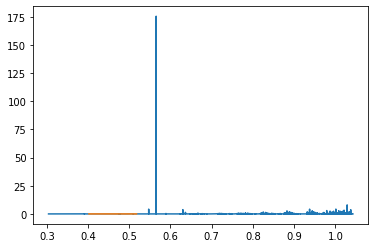

In [80]:
# test out the function: test inputs come from example.py and 

# userinput = {"telescope": "ATLAS_PROBE",  #choices are "SOAR", "Gemini", "ATLAS_PROBE" 
#              "instrument": "ATLAS",#choices are "SAMOS", "SCORPIO", ,GMOX", ATLAS"
#             "band": "atlas_IR",      #other choices are 
#                                   # SAMOS: "LowRed", "LowBlue", "HighRed", "HighBlue"
#                                   # SCORPIO: "g", "r", "i", "z", "Y", "J", "H", "K"
#                                   # GMOX: "Blue", "Red", "J", "H", "K"
#                                   # ATLAS: "atlas_IR"
#             "ADC_is_in": False,    # SCORPIO only, either True of False
#             "time":3600,          #exposure time (s)
#             "slit_width":0.75,    #(arcsec) - Other choices are 
#                                   # SAMOS: 0.167, 0.333, 0.500, 0.667, 0.833, 1.000
#                                   # SCORPIO: 0.36, 0.54, 0.72, 1.08, 1.44, 2.16, 4.32
#                                   # GMOX: 0.083, 0.167, 0.250, 0.333, 0.417, 0.500, 0.583, 0.667, 0.750, 0.833, 0.917, 1.00 
#                                   # ATLAS: 0.75             
#             "Nreads":16,           # for IRs, RON goes with SQRT(Nreads), so this is the Nr of Fowler pairs
#                                   # for CCDs  (all VIS channels) use Nreads = 1 
#             "Detector": "IR_SCA", # either IR_SCA or CCD - will be checked later
#             "theta":0.7,          # extension of the source in the cross dispersion direction (arcsec) 
#             "nExp":6,             # Nr of frames; increases RON, helps saturation, always dither=2 if >0
#             "lineF":-99,          #use -99 for a dummy value
#             "lineW":-99,          #use -99 for a dummy value
#             "FWHM":200,           #Width of the line as emitted by the source, in km/s 
#             "z":0,
#             "specFile":"./templates/Galaxy_Kmag_19_Haflux_5e-17_ebmv_0_z_2_highResSpec_obs_redshift.txt", 
#             "mag":19,
#             "NormalizeUserSpec":True,
#             "InputInAngstroms":True,
#             "SN":-99,             # = -99 to calculate; othersise set "SN"  > 0 to extract time needed to reach the given SNR
#             }

# userinput = {"telescope": "SOAR",  #choices are "SOAR", "Gemini", "ATLAS_PROBE" 
#              "instrument": "SAMOS",#choices are "SAMOS", "SCORPIO", ,GMOX", ATLAS"
#             "band": "LowRed",      #other choices are 
#                                   # SAMOS: "LowRed", "LowBlue", "HighRed", "HighBlue"
#                                   # SCORPIO: "g", "r", "i", "z", "Y", "J", "H", "K"
#                                   # GMOX: "Blue", "Red", "J", "H", "K"
#                                   # ATLAS: "atlas_IR"
#             "ADC_is_in": False,    # SCORPIO only, either True of False
#             "time":3600,          #exposure time (s)
#             "slit_width":0.333,    #(arcsec) - Other choices are 
#                                   # SAMOS: 0.167, 0.333, 0.500, 0.667, 0.833, 1.000
#                                   # SCORPIO: 0.36, 0.54, 0.72, 1.08, 1.44, 2.16, 4.32
#                                   # GMOX: 0.083, 0.167, 0.250, 0.333, 0.417, 0.500, 0.583, 0.667, 0.750, 0.833, 0.917, 1.00 
#                                   # ATLAS: 0.75             
#             "Detector": "CCD",    # either IR_SCA or CCD - will be checked later
#             "Nreads":1,           # for IRs, RON goes with SQRT(Nreads), so this is the Nr of Fowler pairs
#                                   # for CCDs  (all VIS channels) use Nreads = 1 
#             "theta":0.5,          # extension of the source in the cross dispersion direction (arcsec) 
#             "nExp":3,             # Nr of frames; increases RON, helps saturation, always dither=2 if >0
#             "lineF":-99,          #use -99 for a dummy value
#             "lineW":-99,          #use -99 for a dummy value
#             "FWHM":200,           #Width of the line as emitted by the source, in km/s 
#             "z":0,
#             "specFile":"./templates/Galaxy_Kmag_19_Haflux_5e-17_ebmv_0_z_2_highResSpec_obs_redshift.txt", 
#             "mag":20,
#             "NormalizeUserSpec":True,
#             "InputInAngstroms":True,
#             "SN":-99,             # = -99 to calculate; othersise set "SN"  > 0 to extract time needed to reach the given SNR
#             }



userinput = {"telescope": "Gemini",  #choices are "SOAR", "Gemini", "ATLAS_PROBE" 
             "instrument": "SCORPIO",#choices are "SAMOS", "SCORPIO", ,GMOX", ATLAS"
            "band": "g",      #other choices are 
                                  # SAMOS: "LowRed", "LowBlue", "HighRed", "HighBlue"
                                  # SCORPIO: "g", "r", "i", "z", "Y", "J", "H", "K"
                                  # GMOX: "Blue", "Red", "J", "H", "K"
                                  # ATLAS: "atlas_IR"
            "ADC_is_in": True,    # SCORPIO only, either True of False
            "slit_width":0.54,    #(arcsec) - Other choices are 
                                  # SAMOS: 0.167, 0.333, 0.500, 0.667, 0.833, 1.000
                                  # SCORPIO: 0.36, 0.54, 0.72, 1.08, 1.44, 2.16, 4.32
                                  # GMOX: 0.083, 0.167, 0.250, 0.333, 0.417, 0.500, 0.583, 0.667, 0.750, 0.833, 0.917, 1.00 
                                  # ATLAS: 0.75             
            "time":3600,          #exposure time (s)
            "nExp":5,             # Nr of frames; increases RON, helps saturation, always dither=2 if >0
            "Nreads":1,           # for IRs, RON goes with SQRT(Nreads), so this is the Nr of Fowler pairs
                                  # for CCDs  (all VIS channels) use Nreads = 1 
            "detector": "CCD",    # either IR_SCA or CCD - will be checked later
            "frame_readout_time": 0.5, #seconds
            "nr_of_averaged_frames": 8,
            "nr_of_skipped_frames": 0,
            "nr_of_groups": 16,   #groups in a ramp
            "theta":0.5,          # extension of the source in the cross dispersion direction (arcsec) 
            "lineF":-99,          #use -99 for a dummy value
            "lineW":-99,          #use -99 for a dummy value
            "FWHM":200,           #Width of the line as emitted by the source, in km/s 
            "z":0,
            "specFile":"./templates/Galaxy_Kmag_19_Haflux_5e-17_ebmv_0_z_2_highResSpec_obs_redshift.txt", 
            "mag":20,
            "NormalizeUserSpec":True,
            "InputInAngstroms":True,
            "SN":-99,             # = -99 to calculate; othersise set "SN"  > 0 to extract time needed to reach the given SNR
            }
gotit = set_telescope_instrument(userinput)
telescope=gotit['telescope']
instrument=gotit['instrument']

#telescope = dict(gotit)
#instrument = dict(gotit)
#print(telescope)
#print(instrument)
etc_output = general_etc_serena(userinput)

fig = go.Figure(data=[go.Table(header=dict(values=['Variable', 'Value', 'Units']),
                 cells=dict(values=[
                     etc_output["summary_struct"]['quant'],
                     etc_output["summary_struct"]['value'],
                     etc_output["summary_struct"]['unit']]))
                     ])

fig.show()



In [81]:
# For the plots, extract the arrays
bandpass=etc_output['spec_struct']["spec_bandpass"]
wl_0=bandpass[0,0]
wl_1=bandpass[1,0]

my_dict = dict(values=etc_output["spec_struct"]['wave'])
df = pd.DataFrame(data=list(my_dict.items()),columns = ['values','wl'])
wl = df['wl'][0]#wl#.plot()

my_dict = dict(values=etc_output["spec_struct"]['tp'])
df = pd.DataFrame(data=list(my_dict.items()),columns = ['values','tp'])
tp = df['tp'][0]#wl#.plot()

my_dict = dict(values=etc_output["spec_struct"]['bandpass'])
df = pd.DataFrame(data=list(my_dict.items()),columns = ['values','bandpass'])
bandpass = df['bandpass'][0]#wl#.plot()

my_dict = dict(values=etc_output["spec_struct"]['bk'])
df = pd.DataFrame(data=list(my_dict.items()),columns = ['values','bk']) 
bk = df['bk'][0]#wl#.plot()  

my_dict = dict(values=etc_output["spec_struct"]['signal'])
df = pd.DataFrame(data=list(my_dict.items()),columns = ['values','signal'])
signal = df['signal'][0]#wl#.plot()

my_dict = dict(values=etc_output["spec_struct"]['noise'])
df = pd.DataFrame(data=list(my_dict.items()),columns = ['values','noise'])
noise = df['noise'][0]#wl#.plot()

my_dict = dict(values=etc_output["spec_struct"]['sn'])
df = pd.DataFrame(data=list(my_dict.items()),columns = ['values','sn'])
sn = df['sn'][0]#wl#.plot()



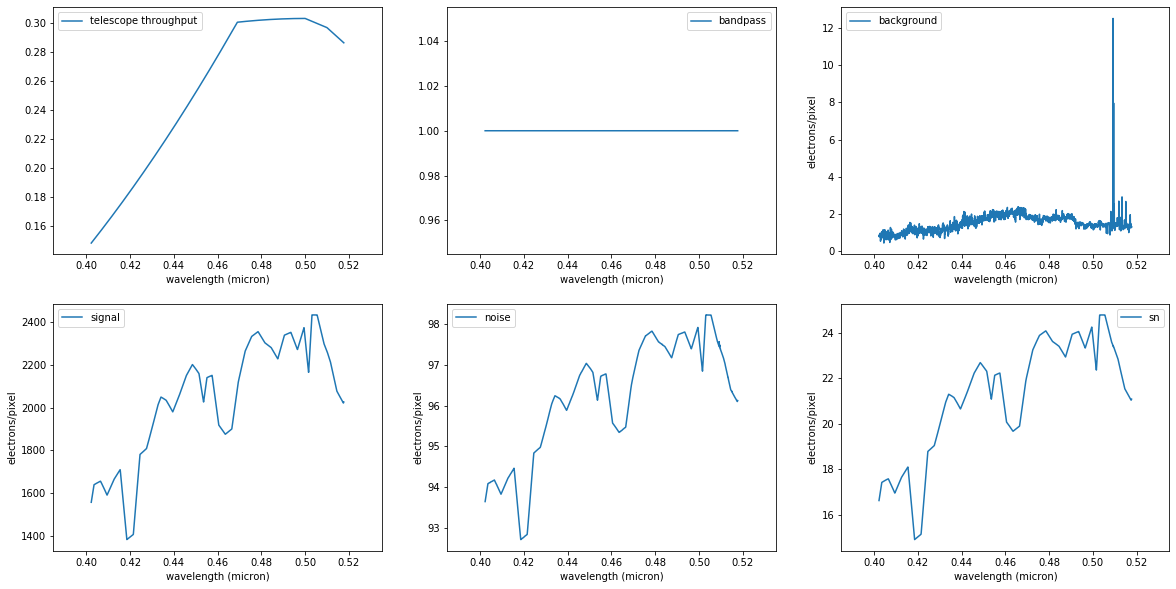

In [82]:
fig, axs = plt.subplots(2, 3,figsize=(20, 10))
axs[0, 0].plot(wl,tp,label='telescope throughput')
axs[0, 0].set_xlabel('wavelength (micron)')
axs[0, 0].set_xlim([wl_0,wl_1])
axs[0, 0].legend()
axs[0, 1].plot(wl,bandpass,label='bandpass')
axs[0, 1].set_xlabel('wavelength (micron)')
axs[0, 1].set_xlim([wl_0,wl_1])
axs[0, 1].legend()
axs[0, 2].plot(wl,bk,label='background')
axs[0, 2].set_xlabel('wavelength (micron)')
axs[0, 2].set_ylabel('electrons/pixel')
axs[0, 2].set_xlim([wl_0,wl_1])
axs[0, 2].legend()
#axs[1, 0].plot(wl,sig,label='sig')
#axs[1, 0].legend()
axs[1, 0].plot(wl,signal,label='signal')
axs[1, 0].set_xlabel('wavelength (micron)')
axs[1, 0].set_ylabel('electrons/pixel')
axs[1, 0].set_xlim([wl_0,wl_1])
axs[1, 0].legend()
axs[1, 1].plot(wl,noise,label='noise')
axs[1, 1].set_xlabel('wavelength (micron)')
axs[1, 1].set_ylabel('electrons/pixel')
axs[1, 1].set_xlim([wl_0,wl_1])
axs[1, 1].legend()
axs[1, 2].plot(wl,sn,label='sn')
axs[1, 2].set_xlabel('wavelength (micron)')
axs[1, 2].set_ylabel('electrons/pixel')
axs[1, 2].set_xlim([wl_0,wl_1])
axs[1, 2].legend()



In [91]:
#print(signal,noise)
random_noise = np.random.randn(len(signal))*noise    # first multiply by normally distributed noise, then by noise ?
example=signal+random_noise #signal with noise added

#print(np.random.randn"(len(signal)))

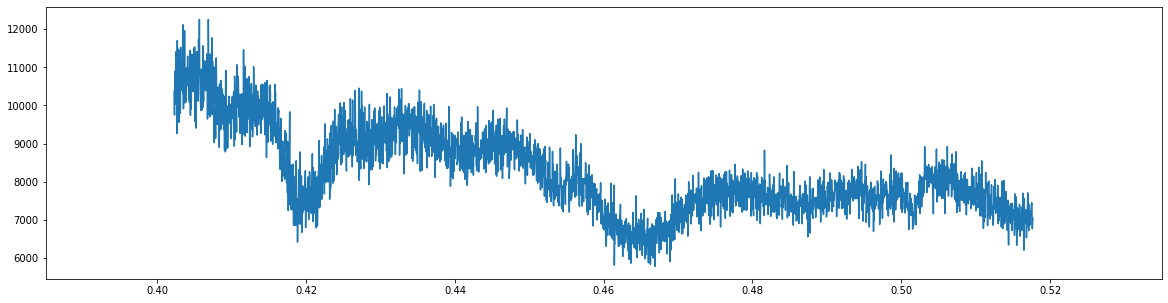

In [92]:
plt.figure(figsize=(20,5))
plt.plot(wl,example/tp)
mmm=np.median(example)
sss=np
plt.xlim([wl_0,wl_1])
plt.show()

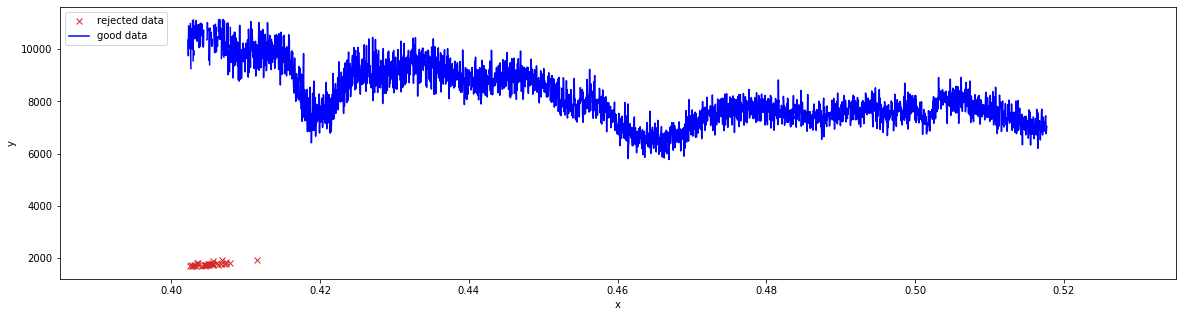

In [93]:
filtered_data = sigma_clip(example/tp, sigma=3, maxiters=1, stdfunc=mad_std) #reject numbers over 3 sigma away from avg)
    #why example/tp?
    # so ..
    
plt.figure(figsize=(20,5))
plt.xlim([wl_0,wl_1])
#plt.ylim([0,max(filtered_data)])
plt.plot(wl[filtered_data.mask], example[filtered_data.mask], 'x', color='#d62728', label="rejected data")
plt.plot(wl, filtered_data, color='blue', label="good data") # this is actual data
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=2, numpoints=1)


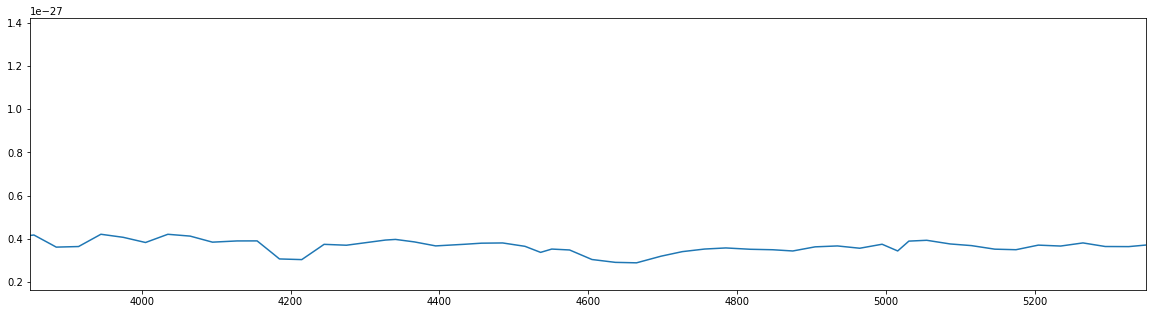

In [86]:
plt.figure(figsize=(20,5))
plt.plot(userspec[:,0],userspec[:,1])
#plt.xlim([wl_0,wl_1])
plt.xlim([wl_0*1E4,wl_1*1E4])
plt.show()

## below is to create a filter of ones and zeros
which will eventually be applied to the example data


(0.385, 0.535)

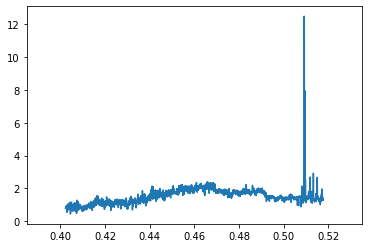

In [94]:
#reload
import sys
import numpy
#numpy.set_printoptions(threshold=sys.maxsize)
numpy.set_printoptions(threshold = False) 

my_dict = dict(values=etc_output["spec_struct"]['bk'])
df = pd.DataFrame(data=list(my_dict.items()),columns = ['values','bk']) 
bk = df['bk'][0]#wl#.plot()  

plt.plot(wl,bk)
plt.xlim(wl_0,wl_1)


## Create a new background filter for visible wavelengths:

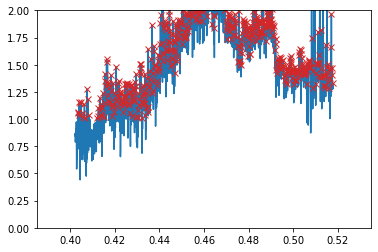

In [99]:
# find peaks, indices
# ---------------- using find peaks just to see what that looks like first ------------------#

peaks,_= find_peaks(bk, height = 1)
new_peak_ind = wl[peaks]

plt.plot(wl,bk)
plt.plot(new_peak_ind,bk[peaks], "x", color='#d62728')
plt.xlim([wl_0,wl_1])
plt.ylim(0,2)
plt.show()


In [100]:
# filter

bkg_noise_filter = np.ones(len(bk))
bkg_noise_filter[peaks] = 0


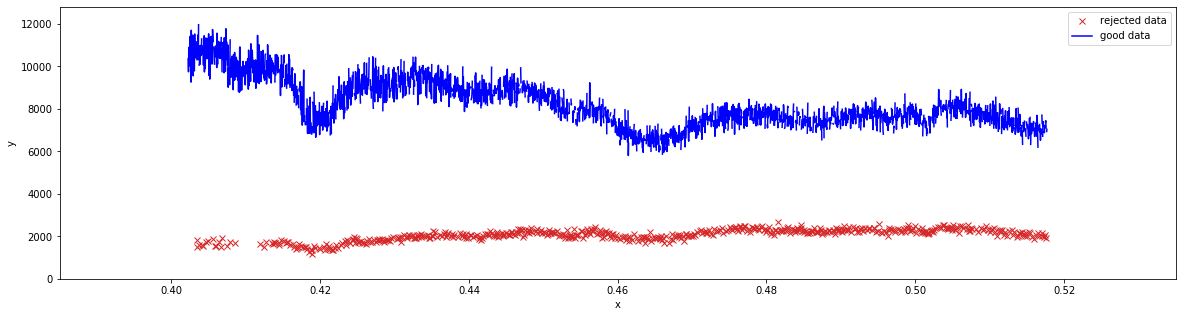

In [101]:
filtered_output_signal = example/tp * bkg_noise_filter

filtered_data_w_bk = sigma_clip(filtered_output_signal, sigma=3, maxiters=1, stdfunc=mad_std) #reject numbers over 3 sigma away from avg)

plt.figure(figsize=(20,5))
plt.xlim([wl_0,wl_1])
#plt.ylim([0,max(filtered_data)])
plt.plot(wl[filtered_data_w_bk.mask], example[filtered_data_w_bk.mask], 'x', color='#d62728', label="rejected data")
plt.plot(wl, filtered_data_w_bk, color='blue', label="good data") # this is actual data
plt.xlabel('x')
plt.ylabel('y')
plt.ylim([0,12800])
plt.legend(loc=1, numpoints=1)

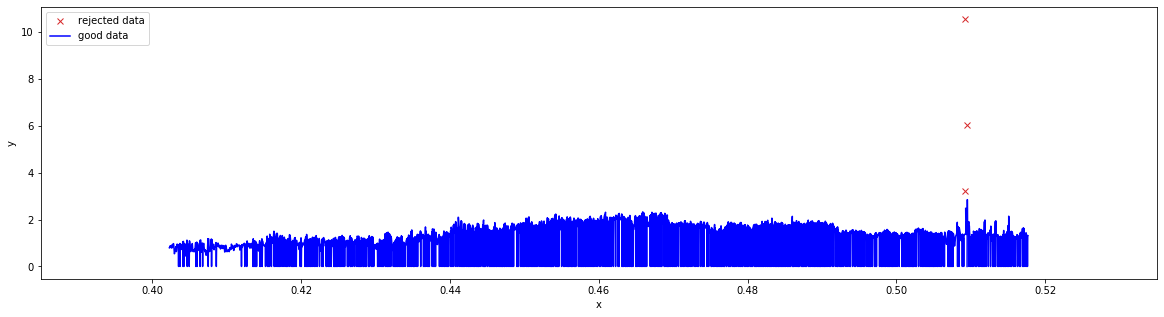

In [103]:
# what the background looks like

background_after_filter = bk
background_after_filter[peaks] = 0

filtered_background = sigma_clip(background_after_filter, sigma=3, maxiters=1, stdfunc=mad_std) #reject numbers over 3 sigma away from avg)
plt.figure(figsize=(20,5))
plt.xlim([wl_0,wl_1])
#plt.ylim([0,max(filtered_data)])
plt.plot(wl[filtered_background.mask], bk[filtered_background.mask], 'x', color='#d62728', label="rejected data")
plt.plot(wl, filtered_background, color='blue', label="good data") # this is actual data
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=2, numpoints=1)



## New SNR calculations (below)

NOTES: 


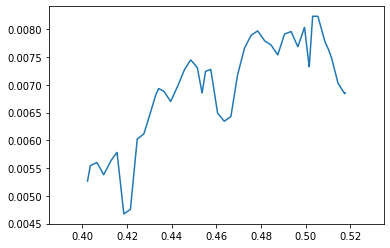

In [104]:
# signal/noise
# bad graph, without background correction

raw_noise_total = sum(noise)
    # each noise contribution array item is placed under the sqrt , but this is sum of all those noise contributions so it is sum of sqrts

snr_raw_noise_total = signal/raw_noise_total
plt.plot(wl,snr_raw_noise_total)
plt.xlim(wl_0,wl_1)
plt.show()

(0.385, 0.535)

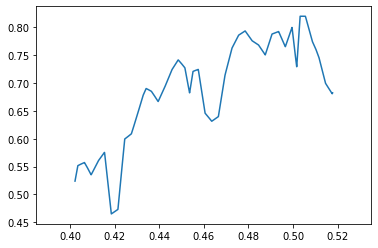

In [105]:
# signal/background, with just the filtered background
# data being used: background_after_filter
    # background_after_filter: background[peaks] = 0

bkg_filtered_total = sum(np.sqrt(background_after_filter))
snr_bkg_filtered_total = signal/((bkg_filtered_total))
plt.plot(wl,snr_bkg_filtered_total)
plt.xlim(wl_0,wl_1)


# still very low snr, not sure why?

(0.385, 0.535)

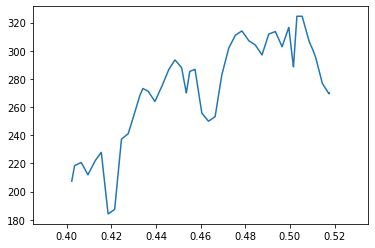

In [106]:
# signal/background
# with the sigma_clip reduced background (in addition to peaks, also gets rid of everything 3 sigma or more)
# data being used: bk[filtered_background.mask]
    # presumably, this is the bk array that is missing anything 3 sigma or more, and values at [peaks]

bkg_filtered_sigma_total = sum(np.sqrt(bk[filtered_background.mask]))
snr_bkg_filtered_sigma_total = signal/((bkg_filtered_sigma_total))
plt.plot(wl,snr_bkg_filtered_sigma_total)
plt.xlim(wl_0,wl_1)

# also low

(1.15, 1.36)

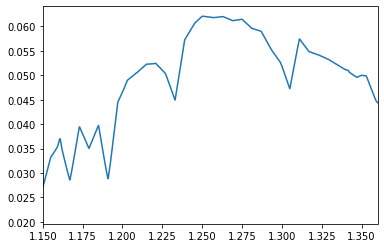

In [29]:
# signal/noise, noise filtered with background filter

noise_bkfilter = noise  #set noise to a new variable so we don't change the original variable
noise_bkfilter[peaks] = 0   #setting the values of the noise that presumably correspond to background to 0; not fully accurate since there may be other noise contributions at the same wavelengths
noise_bkfilter_total = sum(np.sqrt(noise_bkfilter))
snr_noise_bkfilter_total = signal/noise_bkfilter_total
plt.plot(wl,snr_noise_bkfilter_total)
plt.xlim(wl_0,wl_1)

#still very low, hmm...

(1.15, 1.36)

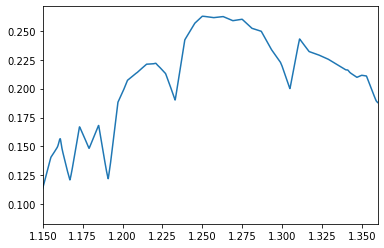

In [30]:
# signal/noise, noise filtered with background filter + sigma cut

noise_bkfilter = noise
noise_bkfilter_sigma = noise_bkfilter[filtered_background.mask]  #presumably, this will cut the bk array 3 sigma or more, and values at [peaks]
noise_bkfilter_sigma_total = sum(np.sqrt(noise_bkfilter_sigma))
snr_noise_bkfilter_sigma_total = signal/noise_bkfilter_sigma_total
plt.plot(wl,snr_noise_bkfilter_sigma_total )
plt.xlim(wl_0,wl_1)

#getting better as expected, but still bad

